# Attention Visualization

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os 
import random
import torch

from models.swiftformer import SwiftFormer
from PIL import Image
from torchvision import transforms
from util.common import common_paths
from util.dataset import INCIDENTS
from util.visualization import get_attn_weights


model = SwiftFormer(
            layers=[3, 3, 3, 3],
            embed_dims=[32, 36,40, 48],
            downsamples=[True, True, True, True],
            vit_num=1)

ckpt_path = common_paths['ckpt_best']
checkpoint = torch.load(ckpt_path)
model.load_state_dict(checkpoint['model'], strict=True)
model.eval() 

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

softmax = torch.nn.Softmax(dim=1)

/cdtemp/richard/coding/swiftformer/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


num_classes: 20


/cdtemp/richard/coding/swiftformer/lib/python3.8/site-packages/torch/cuda/__init__.py:122: UserWarning: 
    Found GPU0 NVIDIA GeForce GTX 645 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))


### Sample Images

/cdtemp/richard/datasets/disaster-150k/val/collapsed/collapsed-14.jpg
/cdtemp/richard/datasets/disaster-150k/val/oil_spill/oil spill-206.jpg
/cdtemp/richard/datasets/disaster-150k/val/on_fire/on fire-567.jpg
/cdtemp/richard/datasets/disaster-150k/val/drought/drought-401.jpg
/cdtemp/richard/datasets/disaster-150k/val/dust_sandstorm/dust sand storm-198.jpg


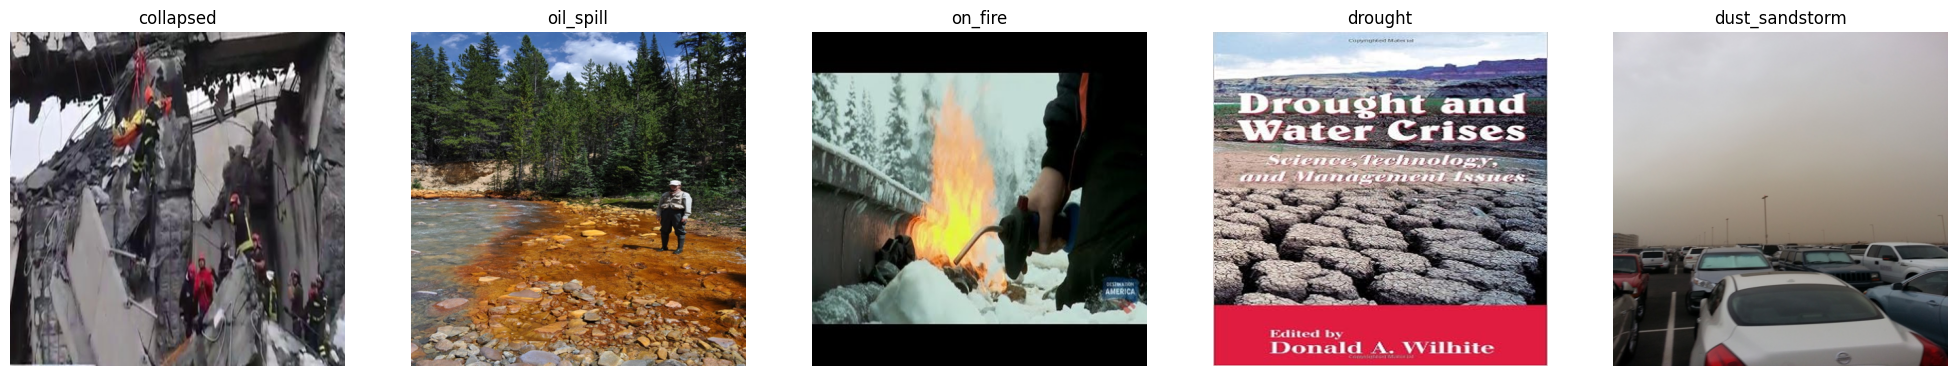

In [2]:
classes = list(INCIDENTS.values())
ds_path = os.path.join(common_paths['dataset_root'], 'val')

def sample_images():
    return

image_list = []
for i in range(5):
    rnd_class = random.choice(classes)
    inc_path = os.path.join(ds_path, rnd_class)
    image_path = os.path.join(inc_path, random.choice(os.listdir(inc_path)))
    image_list.append((rnd_class, image_path))

fig, ax = plt.subplots(1, 5, figsize=(25, 5))
for idx, (inc_class, image_path) in enumerate(image_list):
    img = Image.open(image_path).resize((512,512))
    print(image_path)
    ax[idx].imshow(img)
    ax[idx].axis('off')
    ax[idx].set_title(inc_class)

sample_images()
    

### Forward Passes, Attention Weights

In [3]:
def forward_passes():
    return

maps_list = []
for idx, (inc_class, image_path) in enumerate(image_list):
    img = Image.open(image_path)
    t = transform(img)
    input_tensor = torch.unsqueeze(t,0)
    
    with torch.no_grad():
        res = model(input_tensor)
        prob = softmax(res)
        pred_class_id = int(torch.topk(prob, 1).indices)
        pred_class = INCIDENTS[str(pred_class_id)]
        print(torch.topk(prob, 3))
        print(f"Predicted Class: {pred_class}\n")

    # Global attention query vector for different stages
    attn_stages = [
        model.network[0][2].attn,    # stage 1
        model.network[2][2].attn,    # stage 2
        model.network[4][2].attn,    # stage 3
        model.network[6][2].attn     # stage 4
    ]

    weights = [get_attn_weights(stage) for stage in attn_stages]

    # fuse weights for all stages
    agg = np.array([cv2.resize(arr, weights[0].shape, interpolation=cv2.INTER_CUBIC) for arr in weights]) # all arrays with size of stage 1

    fused_weights = [
        np.mean(agg, axis=0),
        np.max(agg, axis=0),
        np.min(agg, axis=0)
    ]

    maps = {
        f"GT: {inc_class}\nPred.: {pred_class}": np.array(img), 
        "Mean": fused_weights[0], 
        "Stage 1": weights[0],
        "Stage 2": weights[1],
        "Stage 3": weights[2], 
        "Stage 4": weights[3]
    }

    maps_list.append(maps)
    
forward_passes()

torch.return_types.topk(
values=tensor([[0.2376, 0.1618, 0.0784]]),
indices=tensor([[3, 6, 0]]))
Predicted Class: collapsed

torch.return_types.topk(
values=tensor([[0.1508, 0.1235, 0.0814]]),
indices=tensor([[ 7, 12, 11]]))
Predicted Class: flooded

torch.return_types.topk(
values=tensor([[0.2040, 0.1496, 0.0693]]),
indices=tensor([[18, 13,  3]]))
Predicted Class: volcanic_eruption

torch.return_types.topk(
values=tensor([[0.2708, 0.0774, 0.0696]]),
indices=tensor([[ 4,  6, 18]]))
Predicted Class: drought

torch.return_types.topk(
values=tensor([[0.3701, 0.0542, 0.0440]]),
indices=tensor([[ 5,  6, 14]]))
Predicted Class: dust_sandstorm



### Visualization: All attention stages for one image

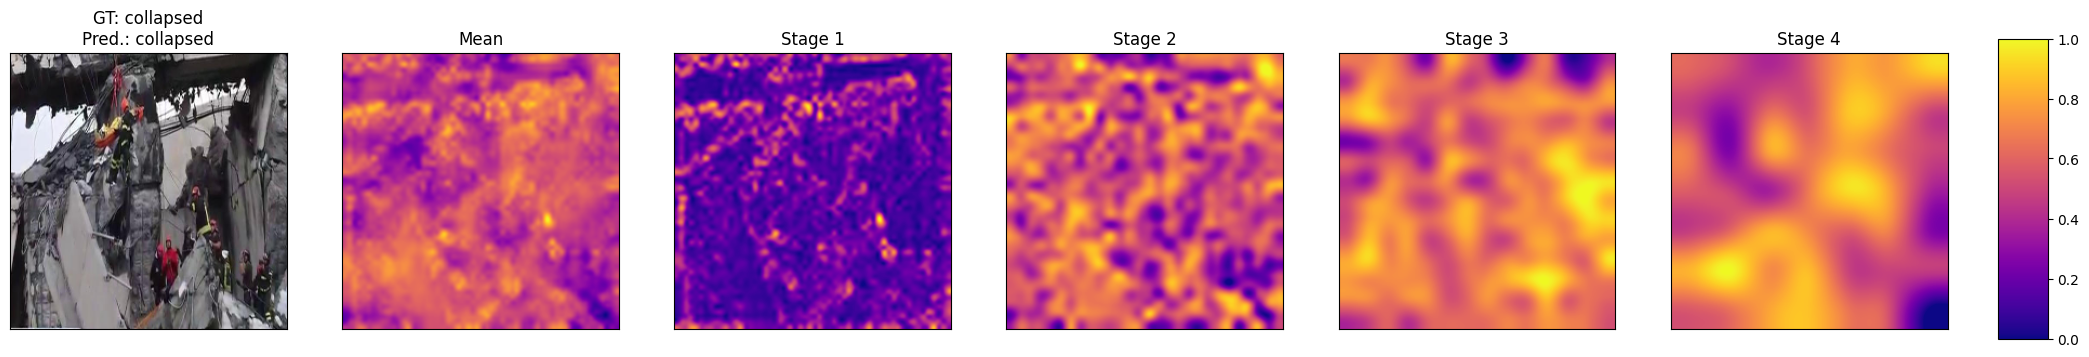

In [4]:
def vis_attn_one():
    return

im_size = (256, 256)
cmap = "plasma"

fig, axes = plt.subplots(1, 6, figsize=(25,5)) 
for idx, (title, map) in enumerate(maps_list[0].items()):
    weights = cv2.resize(map, im_size, interpolation=cv2.INTER_CUBIC)
    axes.flat[idx].imshow(weights, cmap=cmap)
    axes.flat[idx].set_title(title)
    axes.flat[idx].set_xticks([])
    axes.flat[idx].set_yticks([])
cbar_ax= fig.add_axes([0.92,0.2,0.02,0.6]) 
sm=plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
plt.colorbar(sm, cax=cbar_ax)
plt.show()

vis_attn_one()

### Visualization: Mean attention for sample images

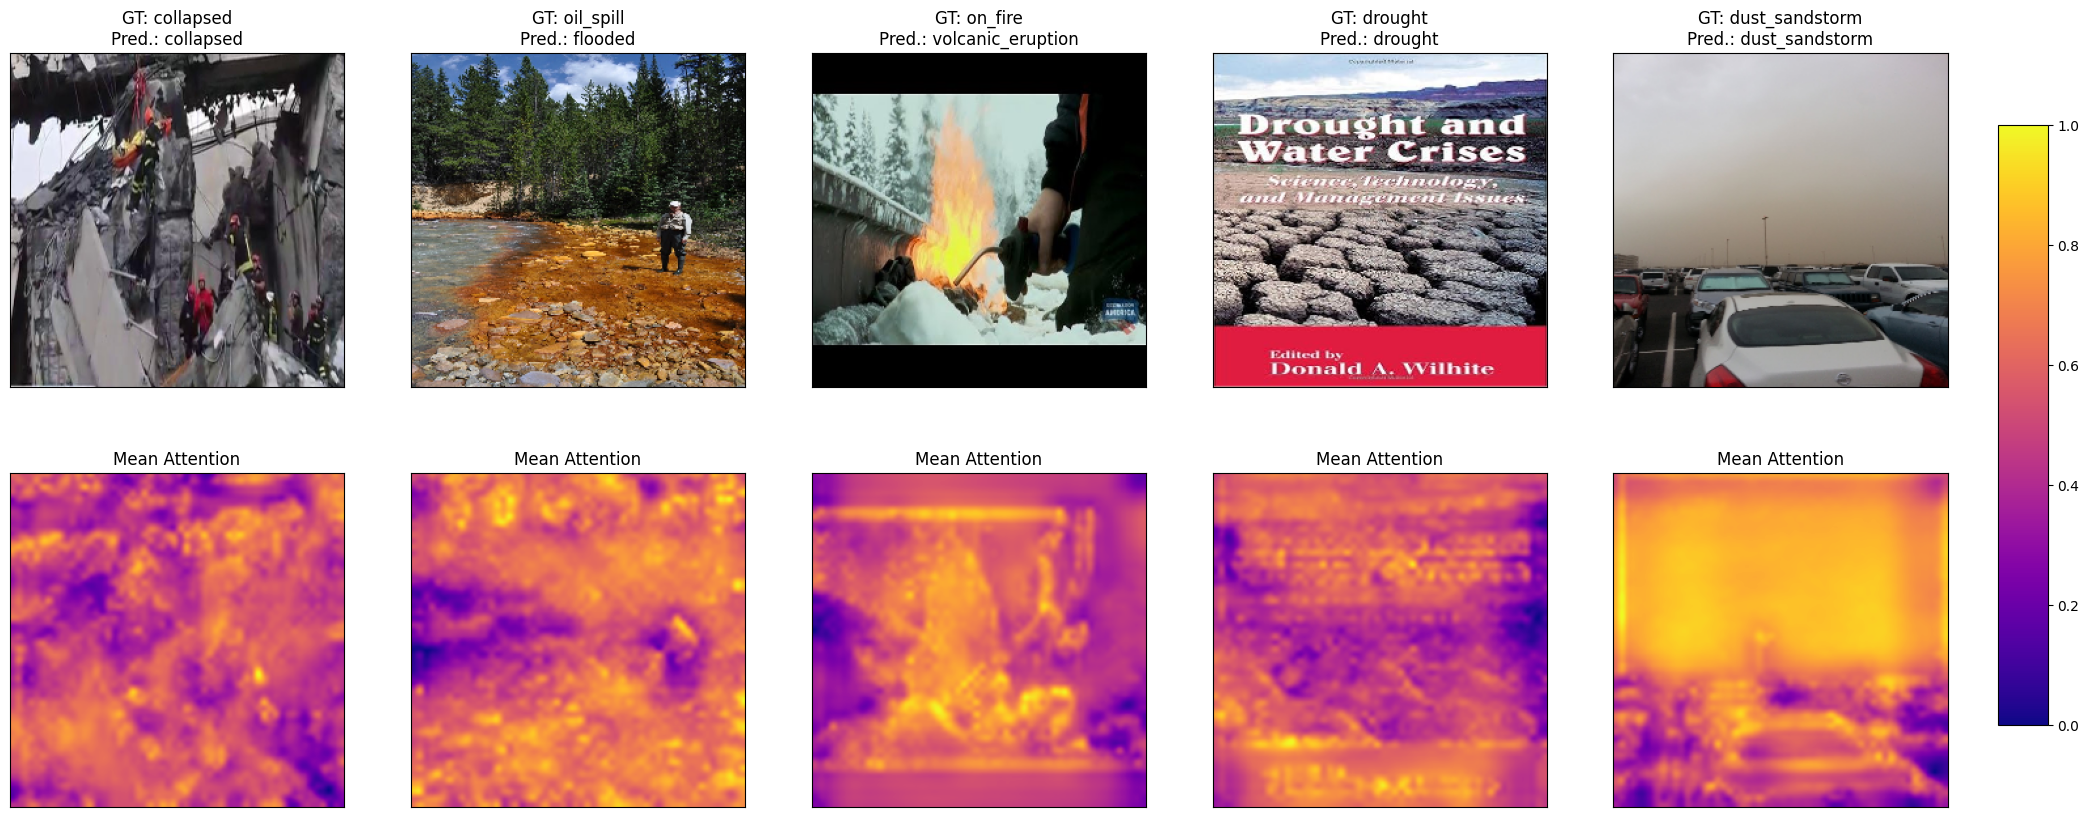

In [7]:
def vis_attn_all():
    return

new_maps = {}
for idx, maps in enumerate(maps_list):
    for k in maps:
        if 'Stage' not in k:
            new_maps[f'{k}_{idx}'] = maps[k] 

ordered_entries = []
for idx in range(int(len(new_maps)/2)):
    for k in new_maps:
        if 'Mean' not in k and str(idx) in k:
            ordered_entries.append(k) 

for idx in range(len(ordered_entries)):
    ordered_entries.append(f'Mean_{idx}')
    
fig, axes = plt.subplots(2, 5, figsize=(25,10)) 
for idx, k in enumerate(ordered_entries):
    title = k
    map = new_maps[k]
    weights = cv2.resize(map, im_size, interpolation=cv2.INTER_CUBIC)
    axes.flat[idx].imshow(weights, cmap=cmap)

    if 'Mean' in title:
        axes.flat[idx].set_title(title[:-2] + ' Attention')
    else:
        axes.flat[idx].set_title(title[:-2])
    axes.flat[idx].set_xticks([])
    axes.flat[idx].set_yticks([])
cbar_ax= fig.add_axes([0.92,0.2,0.02,0.6]) 
sm=plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
plt.colorbar(sm, cax=cbar_ax)
plt.show()

vis_attn_all()

## Repeat

In [8]:
sample_images()
forward_passes()
vis_attn_one()
vis_attn_all()